<a href="https://colab.research.google.com/github/aebongbing/ESAA/blob/main/ESAA_%ED%95%84%EC%82%AC_%EA%B3%BC%EC%A0%9C_20240621.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07. 이미지 분할

이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것

- 모든 픽셀은 어떤 클래스에 속함

- 모든 픽셀에 대한 정답 클래스를 레이블 처리한 데이터셋을 가지고 딥러닝 모델을 훈련시키면 정답 클래스를 알지 못하는 새로운 이미지에 대해서도 배경과 객체를 분리할 수 있음

이미지 분할은 의미 분할과 인스턴스 분할로 구분됨

- 의미분할: 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분

- 인스턴스 분할: 같은 범주에 속하더라도 서로 다른 객체를 구

## 7-1 데이터셋 준비

클래스1: 반려동뮬이 속한 픽셀
클래스2: 반려동물과 인접한 픽셀
클래스3: 위에 속하지 않는 경우/ 주변 픽셀


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [2]:
#이미지 크기
img_w=128
img_h=128
img_c=3
img_shape=(img_w,img_h,img_c)

#모델학습
epoch_num=5
learning_rate=0.0001
buffer_size=1000
batch_size=16

In [4]:
#텐서플로 데이터셋 로드
ds_str='oxford_iiit_pet'
ds,info=tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.WG46G9_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.WG46G9_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [10]:
#이미지 전처리 함수
def preprocess_image(ds):
  #원본 이미지
  img=tf.image.resize(ds['image'],(img_w, img_h))
  img=tf.cast(img, tf.float32)/255.0
  #분할 마스크
  mask=tf.image.resize(ds['segmentation_mask'],(img_w,img_h))
  mask=tf.cast(mask, tf.int32)
  mask=mask-1
  return img, mask # Return both image and mask as a tuple

In [11]:
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [13]:
#샘플 배치 선택
img,mask=next(iter(train_ds))
len(img)

16

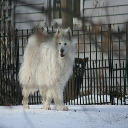

In [14]:
#샘플 이미지 출력
img=np.array(img[0])*255.0
img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

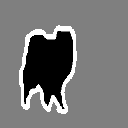

In [15]:
#샘플 마스크 출력
mask=(np.array(mask[0])/2)*255.0
cv2_imshow(mask)

## 7-2 U-Net 모델 (인코더-디코더)

사전학습된 VGG16 모델을 인코더로 활용하는 U-Net 모델을 만들기

In [18]:
#VGG16 모델
base_model=tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

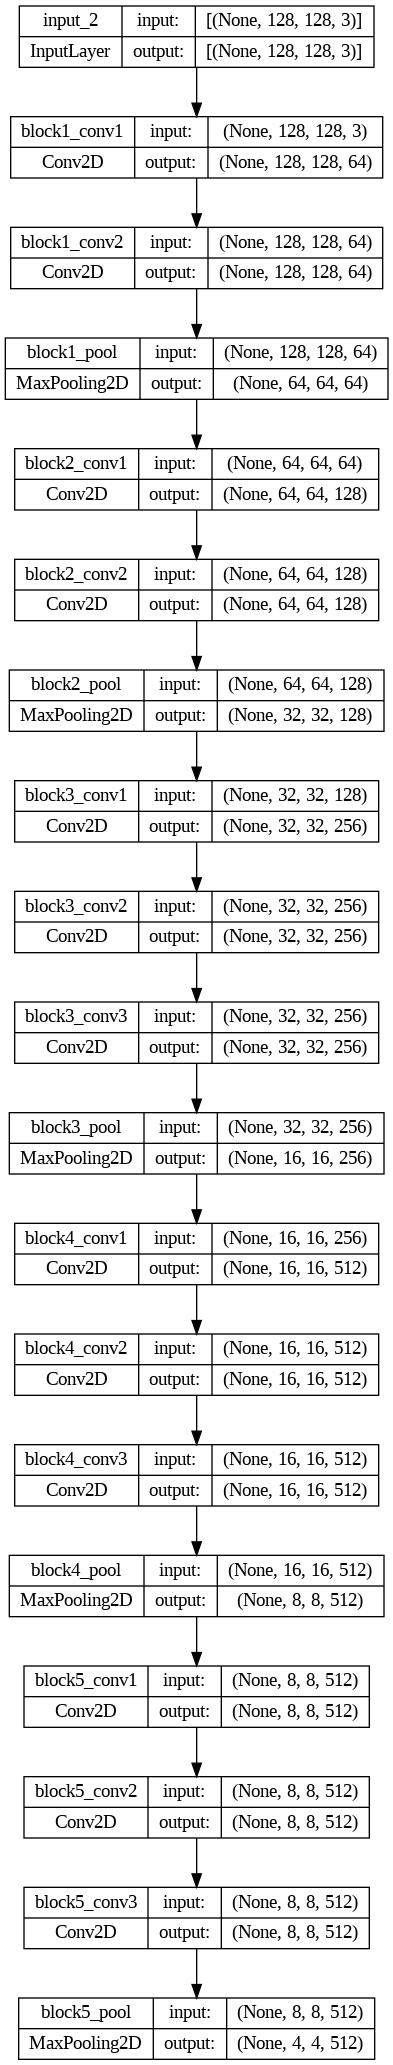

In [19]:
# 모델 구조
tf.keras.utils.plot_model(base_model, show_shapes=True)

만들고자 하는 U-Net의 모양을 미리 정하고, 사전 학습된 모델에서 어느 부분의 어떤 shape의 출력을 가져올지 먼저 정한다. VGG16 모델의 중간 레이어 중에서 필요한 출력 텐서를 지정하여 다양한 피처(특징)를 추출하는 인코더 모델을 정의하게 된다

여기서는 VGG16 모델로부터 5개의 출력을 가져와서 사용한다. 다음과 같이 새로운 Feature Extractor 모델을 정의하고, f_model 변수에 저장한다. 1개의 입력과 5개의 출력을 갖는

In [20]:
#VGG16 중간 레이어 출력 텐서를 지정
f_model=tf.keras.Model(inputs=[base_model.input],
                       outputs=[base_model.get_layer(name='block5_conv3').output,
                                base_model.get_layer(name='block4_conv3').output,
                                base_model.get_layer(name='block3_conv3').output,
                                base_model.get_layer(name='block2_conv2').output,
                                base_model.get_layer(name='block1_conv2').output])

In [21]:
#파라미터 고정
f_model.trainable=False

인코더 부분에서 5개의 출력을 가져와서 디코더의 입력으로 전달하면서 업샘플링한다. 업샘플링은 축소된 이미지를 원래 이미지 크기로 복원하는 과정을 말한다. 제일 작은 (8, 8, 512) 텐서에서 시작해서 조금씩 크기를 키워나가며 중간 출력과 합친다.

In [24]:
# U-Net 구조로 모델 정의

i=tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64=f_model(i)

out=tf.keras.layers.Conv2DTranspose(512,3,strides=2,padding='same')(out_8_8_512)
out=tf.keras.layers.Add()([out, out_16_16_512])

out=tf.keras.layers.Conv2DTranspose(256,3,strides=2,padding='same')(out)
out=tf.keras.layers.Add()([out, out_32_32_256])

out=tf.keras.layers.Conv2DTranspose(128,3,strides=2,padding='same')(out)
out=tf.keras.layers.Add()([out, out_64_64_128])

out=tf.keras.layers.Conv2DTranspose(64,3,strides=2,padding='same')(out)
out=tf.keras.layers.Add()([out, out_128_128_64])

out=tf.keras.layers.Conv2D(3,3,activation='elu', padding='same')(out)
out=tf.keras.layers.Dense(3,activation='softmax')(out)

unet_model=tf.keras.Model(inputs=[i], outputs=[out])

U-net 모델을 시각화한다 인코더의 중간 출력이 업샘플링 과정에서 디코더의 중간 출력과 합쳐지는 것을 확인할 수 있다. 각 레이어의 입출력 텐서 크기를 잘 살펴본다

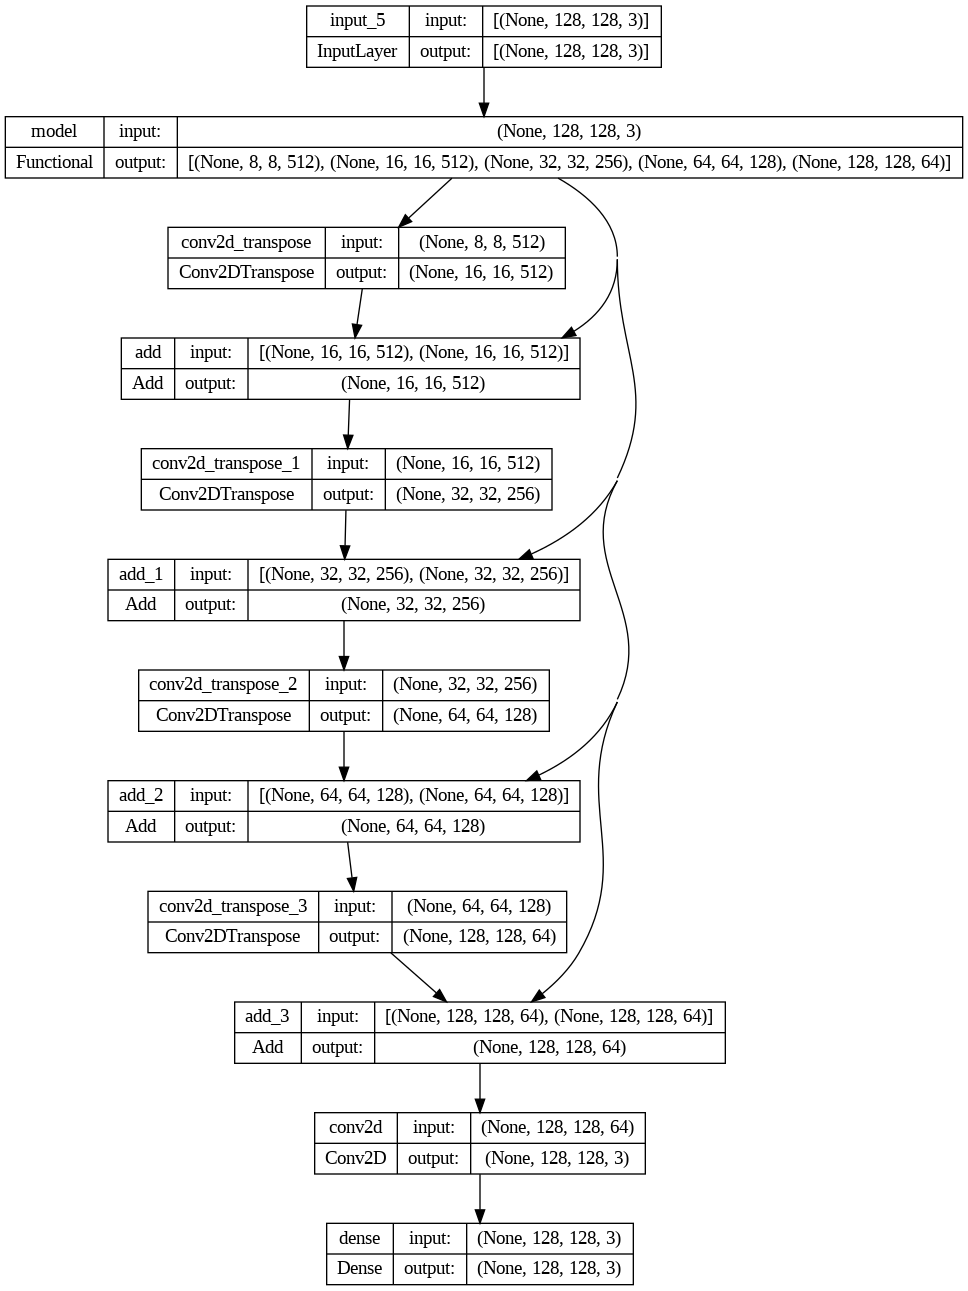

In [25]:
#모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

모델 구조를 요약하면 다음과 같다. 인코더 출력에 사용하기 위해 f_model 로부터 유래하는 5개의 레이어의 14,714,688개의 파라미터는 학습되지 않도록 고정돼 있다.

In [26]:
#모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 8, 8, 512),          1471468   ['input_5[0][0]']             
                              (None, 16, 16, 512),        8                                       
                              (None, 32, 32, 256),                                                
                              (None, 64, 64, 128),                                                
                              (None, 128, 128, 64)]                                               
                                                                                            

예측 클래스 개수가 3개인 다중 분류 문제에 맞도록 SparseCategoricalCrossentropy 손실함수를 설정하고, Adam 옵티마이저를 적용한다. 기본 성능을 확인하는 수준에서 3epoch만 훈련한다.

In [28]:
#모델 컴파일 및 훈련
loss_f=tf.losses.SparseCategoricalCrossentropy()
opt=tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds,batch_size=batch_size, epochs=1)

230/230 [==============================] - 1294s 6s/step - loss: 0.6081 - accuracy: 0.7930


검증 셋의 배치를 하나 선택하고 predict() 매소드로 이미지 분할 클래스를 예측한다. 배치를 구성하는 이미지 중에서 첫 번째 이미지의 분할 결과를 노트북에 출력한다

1/1 [==============================] - 4s 4s/step


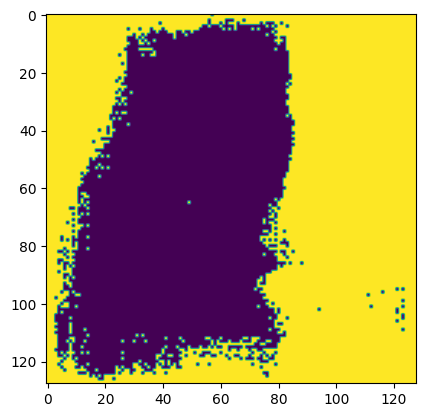

In [29]:
#1개 배치(16개 이미지)를 선택
img,mask=next(iter(test_ds))

#모델 예측
pred=unet_model.predict(img)

#첫 번째 이미지 분할 결과를 출력
pred_img=np.argmax(pred[0],-1)
plt.imshow(pred_img)

정답 마스크 이미지를 출력하고 앞서 예측한 분할 이미지와 비교한다. 어느 정도 객체의 경게를 찾아내는 것을 확인할 수 있다

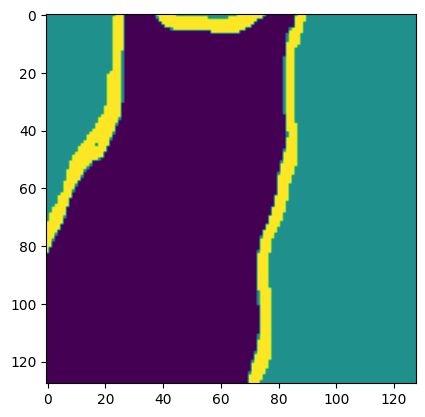

In [30]:
#첫 번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0],(128,128)))